In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks_v2 import *
from helper.orderbook_trader import *


# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
filename_train = '/home/axel/data/obs_2016-11_USDT_BTC_range1.2.dict'
V = 100
vol_intervals = 10
T = 4
P = 15
state_variables=['volume','time']


actions = list(np.linspace(-0.4, 1.0, num=15))
print("V={}, T={}, P={}".format(V, T, P))
print("Actions: ", ", ".join(["{:1.2f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

V=100, T=4, P=15
Actions:  -0.40, -0.30, -0.20, -0.10, -0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00
Length of episodes_train: 541


### Settings

In [3]:
STATE_DIM = len(state_variables)
NUM_ACTIONS = len(actions)
print(STATE_DIM)
print(NUM_ACTIONS)

2
15


In [4]:
def base_model(input_dim=2, output_dim=15):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', init='glorot_normal'))
    model.add(Dense(output_dim, activation='linear', init='glorot_normal'))
    model.compile(loss='mse', optimizer='Adam')
    return model
model = base_model()

In [5]:
def state_as_string(time_left, volume_left, orderbook=None, state_variables=['volume', 'time']):   
        assert isinstance(time_left, int), "Parameter 'time_left' must be of type 'int', given: '{}'".format(type(time_left))
        assert isinstance(volume_left, (int, float)), "Parameter 'volume_left' must be of type 'int' or 'float', given: '{}'".format(type(volume_left))
        assert isinstance(orderbook, OrderbookContainer ) or orderbook is None, "Parameter 'orderbook' [if provided] must be of type 'Orderbook', given: '{}'".format(type(orderbook))

        allowed_variable_set = ['volume', 'time', 'spread']
        assert set(state_variables).issubset(allowed_variable_set), "Parameter 'state_variables' must be a subset of {}".format(allowed_variable_set)

        state = []
        for var in state_variables:
            if var == 'volume':
                state.append(volume_left/100.)
            elif var == 'time':
                state.append(time_left)
            elif var == 'spread':
                if orderbook is None:
                    state.append(0)
                    continue
                
                spread = orderbook.get_ask() - orderbook.get_bid()

                if spread <= 1.:
                    spread_discrete = 0
                elif spread > 2.:
                    spread_discrete = 2
                else:
                    spread_discrete = 1
                state.append(spread_discrete)
            else:
                raise NotImplemented

        return np.array(state)

/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


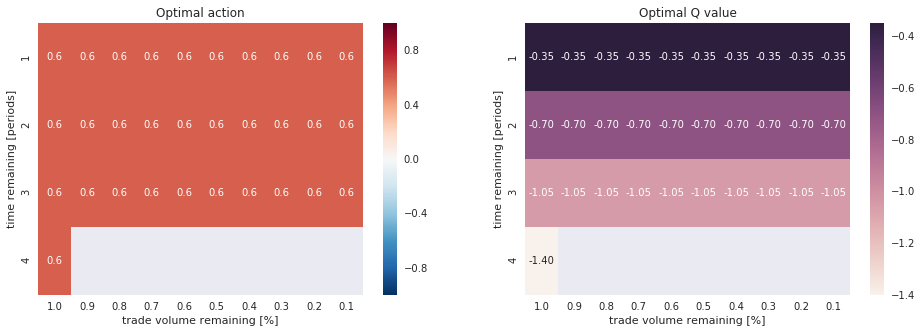

In [6]:
def plot_Q(model, z_represents='action', vol_intervals=10, T=4, epoch=None,
           outfile=None, outformat='pdf', verbose=False, state_variables=['volume', 'time']):
        assert isinstance(z_represents, str) and z_represents in ['action', 'Q']
        
        state_dim = len(state_variables)
        
        timesteps = range(1, T+1)
        grey_tones = np.linspace(1, 0.3, num=T)
        
        fig = plt.figure()
        ax = [fig.add_subplot(111, projection='3d')]
        V = 100
        volumes = np.linspace(0, 1, num=vol_intervals+1)[1:]
        volumes_base = V / vol_intervals
        length = T * vol_intervals
        

        x_offset = 0.5
        y_offset = 0.5*volumes_base

        xpos = []
        ypos = []
        zpos = [0] * length

        dx = np.ones(length) / vol_intervals 
        dy = np.ones(length)
        dz_action = []
        dz_q = []

        colors = []
        
        for t in timesteps:
            for v in volumes:
                state = state_as_string(time_left=t,
                                        volume_left=v)
                if len(state_variables) > 2:
                    state = np.concatenate((state, np.ones(len(state_variables)-2)))
                
                xpos.append(t-x_offset)
                ypos.append(v-y_offset)
                colors.append((grey_tones[t-1], grey_tones[t-1], grey_tones[t-1]))
                
                q = model.predict(state.reshape(1, state_dim))

                dz_action.append(actions[np.nanargmin(q)])
                dz_q.append(10+np.nanmin(q))

        if z_represents == 'action':
            ax[0].bar3d(ypos, xpos, zpos, dx, dy, dz=dz_action, color=colors, alpha=0.5)
            ax[0].set_zlabel("optimal action")
        elif z_represents == 'Q':
            ax[0].bar3d(ypos, xpos, zpos, dx, dy, dz=dz_q, color=colors, alpha=1)
            ax[0].set_zlabel("Q Value")

        # layout
        for axis in ax:
            axis.set_ylabel("time remaining [periods]")
            # axis.set_xlim3d((y_offset,self.volumes[-1]+y_offset))
            axis.invert_xaxis()
            
            axis.set_ylim3d((x_offset,T+x_offset))
            axis.set_yticks(timesteps)
            axis.invert_yaxis()
            
            axis.set_xlabel("trade volume remaining [%]")
            axis.set_xticks(volumes)
            plt.tight_layout()       

        title = "Q function (T:{}, V:{})".format(T*P, V)
        if epoch is not None:
            title = "{}, epochs:{}".format(title, epoch+1)
        fig.suptitle(title)

        if outfile:
            if outfile[len(outformat):] != outformat:
                outfile = "{}.{}".format(outfile, outformat)
            plt.savefig(outfile, format=outformat)

            if verbose:
                print("Successfully saved '{}'".format(outfile))
        else:
            plt.show()
        plt.close()
        
def heatmap_Q(model, vol_intervals, T, hue='Q', state_variables=['volume', 'time']):

    state_dim = len(state_variables)
    timesteps = range(1, T+1)
    volumes = np.linspace(0, 1, num=vol_intervals+1)[1:]
    
    df = pd.DataFrame([], columns=['time', 'volume', 'q', 'action'])
    
    for t in timesteps:
            for v in volumes:
                if t == timesteps[-1] and v !=1.0:
                    continue
                state = state_as_string(time_left=t,
                                        volume_left=v)
                
                q = model.predict(state.reshape(1, state_dim))
                
                df_tmp = pd.DataFrame({'time': t,
                                       'volume': v,
                                       'q': np.nanmin(q),
                                      'action': actions[np.nanargmin(q)]}, index=["{},{:1.2f}".format(t, v)])
                df = pd.concat([df, df_tmp])
    df['time'] = df.time.astype(int)

    fig, axs = plt.subplots(ncols=2, figsize=(16,5))
    plt.suptitle="X"
    sns.heatmap(df.pivot('time', 'volume', 'action'), annot=True, fmt="1.1f",
                ax=axs[0], vmin=actions[0], vmax=actions[-1])
    sns.heatmap(df.pivot('time', 'volume', 'q'), annot=True, fmt="1.2f", ax=axs[1])

    for ax in axs:
        ax.invert_xaxis()
        ax.set_ylabel("time remaining [periods]")
        ax.set_xlabel("trade volume remaining [%]")
        # ax.set_zlabel("trade volume remaining [%]")
    axs[0].set_title('Optimal action')
    axs[1].set_title('Optimal Q value')
    plt.show()

heatmap_Q(model=model, vol_intervals=10, T=T, hue='q', state_variables=['volume', 'time'])

In [7]:
def train_RL(orderbooks, V, T, P, epochs, model=None, gamma=0.95, DECAY_RATE=0.005, epsilon=1.,
             bufferSize=100, batchSize=50, verbose=False, state_variables=['volume', 'time']):

    state_dim = len(state_variables)    
    model = model or base_model(input_dim=state_dim, output_dim=NUM_ACTIONS)
    
    MAX_EXPLORATION_RATE = 1.
    MIN_EXPLORATION_RATE = 0.05
    
    min_costs = np.inf

    replay = Memory(bufferSize)
    # stores tuples of (S, A, R, S')

    for i_episode, episode in tqdm(enumerate(orderbooks)):
        for e in range(epochs):
            ots = OrderbookTradingSimulator(orderbooks=episode, volume=V, tradingperiods=T,
                                                        period_length=P)

            time_left = T
            volume = V
            action_history = []

            state = state_as_string(time_left=time_left,
                                    volume_left=volume,
                                    orderbook=episode[0], state_variables=state_variables)

            acc_cost = 0
            for step in range(T):
                qval = model.predict(state.reshape(1, state_dim))

                ob = episode[step*P]

                if random.random() < epsilon:
                    # choose random action
                    action = random.choice(actions)
                    
                    if step < 2:
                        action = random.choice(actions[:2])
                    
                    print(step, action, ots.volume)
                else:
                    # choose best action from Q(s,a) values
                    action = actions[np.argmin(qval)]
                action_history.append(action)    
                if verbose:
                    print("{}: action {}".format(action, actions[action]))

                limit = ob.get_ask() * (1. + (action/100.))
                info = ots.trade(limit=limit, verbose=False, extrainfo={'ACTION':action})  #agression_factor=action

                time_left -= 1
                volume = float(ots.volume)

                new_state = state_as_string(time_left=time_left,
                                            volume_left=volume,
                                            orderbook=episode[(1+step)*P-1], state_variables=state_variables)
                cost = ots.history.cost.values[-1]

                acc_cost += cost

                replay.add((state, action, cost, new_state))
                if (replay.size() >= batchSize):
                    # wait for buffer to be filled, before getting started with training
                    minibatch = replay.get_random_samples(batchSize)           

                    X_train = []
                    y_train = []
                    for memory in minibatch:
                        state_m, action_m, cost_m, new_state_m = memory

                        qval_old = model.predict(state_m.reshape(1, state_dim))               
                        y = np.zeros((1, NUM_ACTIONS))
                        y[:] = qval_old[:]

                        qval_new_m = model.predict(new_state_m.reshape(1, state_dim), batch_size=1)
                        maxQ = np.max(qval_new_m)

                        update = cost_m + (gamma*maxQ)
                        y[0][action_m] = update  # target output

                        X_train.append(state_m.reshape(state_dim,))
                        y_train.append(y.reshape(NUM_ACTIONS,))
                    X_train = np.array(X_train)
                    y_train = np.array(y_train)

                    print("Game #: %s" % (i_episode,))
                    model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
                state = new_state
                if volume == 0:
                    # display(ots.history)
                    break

            # reduce exploration rate
            if epsilon > MIN_EXPLORATION_RATE:
                epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)

            info = "{} - {:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, steps: {} (t={})\n"\
                    .format(e, i_episode+1, epochs, epsilon,  acc_cost, step, ots.t)
            print(info)
    return model

In [8]:
V=100
T=4
P=15

model = train_RL(orderbooks=episodes_train[:1], V=V, T=T, P=P, epochs=10, model=None,
                 verbose=False, state_variables=['volume', 'time'])

0it [00:00, ?it/s]

0 -0.3 100
1 -0.3 100
2 -0.1 100
3 0.2 99.07547351
0 -    1/10: epsilon=1.000, acc_cost: 0.92344, steps: 3 (t=60)

0 -0.4 100
1 -0.3 100
2 0.6 100
1 -    1/10: epsilon=1.000, acc_cost: 0.27112, steps: 2 (t=44)

0 -0.3 100
1 -0.4 100
2 0.3 100
3 0.3 9.13808194
2 -    1/10: epsilon=1.000, acc_cost: 0.23538, steps: 3 (t=60)

0 -0.3 100
1 -0.4 100
2 0.4 100
3 -    1/10: epsilon=1.000, acc_cost: 0.25492, steps: 2 (t=45)

0 -0.3 100
1 -0.3 100
2 0.7 100
4 -    1/10: epsilon=1.000, acc_cost: 0.29822, steps: 2 (t=43)

0 -0.3 100
1 -0.4 100
2 -0.4 100
3 0.8 100
5 -    1/10: epsilon=1.000, acc_cost: 0.21384, steps: 3 (t=55)

0 -0.4 100
1 -0.4 100
2 0.1 100
3 0.6 97.15615464
6 -    1/10: epsilon=1.000, acc_cost: 0.19200, steps: 3 (t=55)

0 -0.3 100
1 -0.4 100
2 0.4 100
7 -    1/10: epsilon=1.000, acc_cost: 0.25492, steps: 2 (t=45)

0 -0.4 100
1 -0.4 100
2 -0.1 100
3 -0.3 99.07547351
8 -    1/10: epsilon=1.000, acc_cost: 0.92344, steps: 3 (t=60)

0 -0.3 100
1 -0.4 100
2 -0.2 100
3 0.6 99.07547351


1it [00:50, 50.53s/it]

9 -    1/10: epsilon=1.000, acc_cost: 0.19468, steps: 3 (t=55)



/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


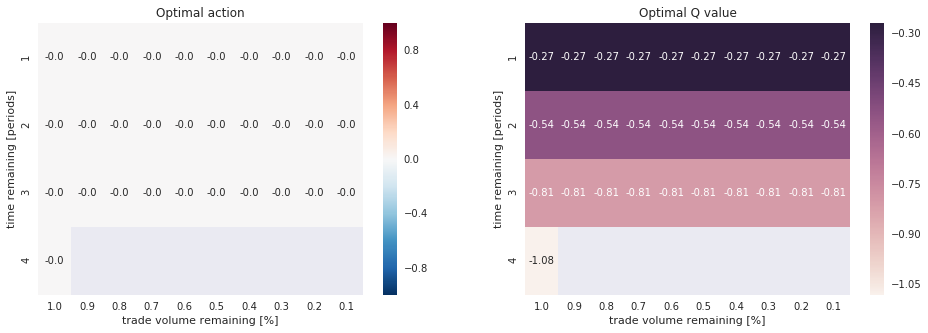

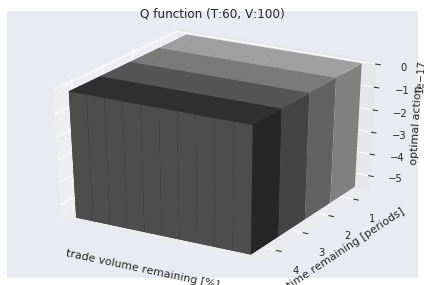

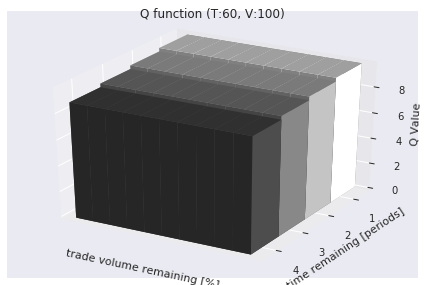

In [9]:
heatmap_Q(model=model, vol_intervals=vol_intervals, T=T)
plot_Q(model=model, z_represents='action', state_variables=['volume', 'time'])
plot_Q(model=model, z_represents='Q', state_variables=['volume', 'time'])

In [ ]:
def run(V, T, P, epochs=1, overwrite_actions=None):
    for i_episode in range(epochs):
        ots = OrderbookTradingSimulator(orderbooks=episode_windows[1], volume=V,
                                        tradingperiods=T, period_length=P)
        plot_episode(episode_windows[1], volume=V)
        time_left = P*T
        volume = V

        state = np.array([time_left, volume])  # , volume])
        # state = discretize_state(state)

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            
            action = actions[np.argmin(qval)]
            
            if overwrite_actions and step < len(overwrite_actions):
                action = overwrite_actions[step]

            # info = ots.trade(orderbooks, limit=lim, verbose=False)
            info = ots.trade(agression_factor=action, verbose=False, extrainfo={'ACTION':action})

            time_left -= 1
            volume = ots.volume
            new_state = np.array([time_left, volume])  # , volume])
            cost = ots.history.cost.values[-1]

            acc_cost += cost

            state = new_state
            if volume == 0:
                break

        info = "{:4d}/{}: acc_cost: {:0.5f}, steps: {} (t={})"\
                .format(i_episode+1, epochs, acc_cost, step, ots.t)
        print(info)
    return ots.history
hist = run(V=V, T=T, P=P)  #, overwrite_actions=[0,0,0,0,0,0,0,0,0])
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.7]*10)
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8])
display(hist)